In [ ]:
#dependencies
!pip install python-chess
import numpy as np
from chess.pgn import Game
from chess import Board
from typing import List
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
import chess.pgn
import numpy as np
from tqdm import tqdm
import os
from torch.utils.data import random_split
from datasets import load_from_disk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 31.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.2-py3-none-any.whl size=147775 sha256=5c9081b6a9e5b2b68981f43698c4dcb51d42f439e66c60d1a0391a1d39dd0583
  Stored in directory: /root/.cache/pip/wheels/fb/5d/5c/59a62d8a695285e59ec9c1f66add6f8a9ac4152499a2be0113
Successfully built chess


In [ ]:
#CNN

class ChessCNN(nn.Module):
    #model architecture: input -> conv2d -> relu -> conv2d -> relu -> conv2d -> relu -> flatten -> linear -> relu -> linear
    #input is an 8 x 8 matrix (representing a chess board) with 13 channels (12 for each unique piece and 1 for legal moves)
    #num_classes is the total number of unique moves in the dataset

    def __init__(self, num_classes):
        super().__init__()

        self.conv1 = nn.Conv2d(13,64,3,stride=1,padding=1)
        self.conv2 = nn.Conv2d(64,64,3,stride=1,padding=1)
        self.conv3 = nn.Conv2d(64,128,3,stride=1,padding=1)

        self.fc1 = nn.Linear(8*8*128,512)
        self.fc2 = nn.Linear(512,num_classes)

        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))

        x = self.flatten(x)

        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [ ]:
#auxiliary functions

#returns a tensor representation of a chess board. Tensor is of shape (13,8,8)
#requires: board is of type Board
def board_to_tensor(board: Board):
    tensor = np.zeros((13,8,8))
    piece_map = board.piece_map()
    for square, piece in piece_map.items():
        row,col = divmod(square,8)
        piece_type = piece.piece_type - 1
        piece_color = 0 if piece.color else 6
        tensor[piece_type + piece_color, row, col] = 1

    legal_moves = board.legal_moves
    for move in legal_moves:
        to_square = move.to_square
        row_to, col_to = divmod(to_square,8)
        tensor[12,row_to,col_to] = 1

    return tensor

#returns an np.array of board tensors and an np.array of labels, where the board tensors are (13,8,8) and the labels are uci formatted strings.
#label y_i is the move that was played in position X_i
#requires: games is of type List[Game]
def games_to_input(games: List[Game]):
    X = []
    y = []
    for game in games:
        board = game.board()
        for move in game.mainline_moves():
            X.append(board_to_tensor(board))
            y.append(move.uci())
            board.push(move)
    return X, y

#returns an np.array of moves encoded as ints, a dict mapping moves to ints, and a dict mapping ints to moves.
#requires: moves is a list of uci formatted strings
def encode_moves(moves):
    unique_moves = list(set(moves))
    move_to_int = {move: int for int, move in enumerate(unique_moves)}
    int_to_move = {int: move for int, move in enumerate(unique_moves)}
    moves = [move_to_int[move] for move in moves]
    return np.array(moves, dtype=np.float32), move_to_int, int_to_move

def fen_and_moves_to_input(fen,moves):
    X = []
    y = [] 
    board = Board(fen)
    uci_list = moves.split()
    board.push(chess.Move.from_uci(uci_list[0]))
    uci_list = uci_list[1:]
    for uci in uci_list:
        tensor = board_to_tensor(board)
        label = uci
        X.append(tensor)
        y.append(label)
        board.push(chess.Move.from_uci(uci))
    return X, y

In [ ]:
#custom dataset

#X are the board tensors and y are the labels
class ChessDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    def __len__(self):
        return len(self.X)

In [ ]:
#training loop

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

print("loading games...")
max_games_per_file = 5000
games = []
for filename in os.listdir("./data"):
    if filename.endswith(".pgn"):
        pgn = open(f"./data/{filename}")
        i = 0
        while True and i<=max_games_per_file:
          game = chess.pgn.read_game(pgn)
          if game is None:
            break
          else:
            games.append(game)
          i += 1
print("games loaded")

max_games = 10000
games = games[:max_games]

print("converting games to input...")
X, y = games_to_input(games)
print("games converted")

print("loading puzzle dataset")
puzzle_dset = load_from_disk("./data/chess_puzzles")
i = 0
for row in puzzle_dset:
   if i >= 800000:
      break
   fen = row["FEN"]
   moves = row["Moves"]
   X_puzzle, y_puzzle = fen_and_moves_to_input(fen,moves)
   X.extend(X_puzzle), y.extend(y_puzzle)
   i += (len(moves) - 1)
print("puzzle dataset loading finished")

X = np.array(X, dtype=np.float32)
y = np.array(y)

y, moves_to_int, int_to_moves = encode_moves(y)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

num_inputs = len(y)
num_classes = len(moves_to_int)
print(f"number of inputs = {num_inputs}")
print(f"number of classes = {num_classes}")

dataset = ChessDataset(X,y)

val_ratio = 0.1
val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - val_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

model = ChessCNN(num_classes=num_classes).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10
saved_val_loss = float('inf')  # initialize to track best val loss

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for input, label in tqdm(train_loader):
        input = input.to(device)
        label = label.to(device)
        output = model(input)
        loss = loss_fn(output, label)
        loss.backward()
        total_loss += loss.item() * input.size(0)
        optimizer.step()
        optimizer.zero_grad()
    saved_loss = total_loss / len(train_loader.dataset)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for input, label in tqdm(val_loader):
            input = input.to(device)
            label = label.to(device)
            output = model(input)
            loss = loss_fn(output, label)
            total_val_loss += loss.item() * input.size(0)
    temp_val_loss = total_val_loss / len(val_loader.dataset)

    if temp_val_loss < saved_val_loss:
        saved_val_loss = temp_val_loss
    else:
        print("Validation loss increased; stopping training.")
        break


    print(f"training loss for epoch{epoch} = {saved_loss}")
    print(f"validation loss for epoch{epoch} = {saved_val_loss}")

os.makedirs("./checkpoints", exist_ok=True)

torch.save(model.state_dict(), f"./checkpoints/num_epochs={num_epochs}_loss={saved_loss: .4f}.pth")

Using device:  cuda
loading games...
games loaded
converting games to input...
games converted
number of inputs = 810600
number of classes = 1847


100%|██████████| 2534/2534 [00:02<00:00, 937.07it/s]


training loss for epoch0 = 4.645299374801331
validation loss for epoch0 = 3.71737335787683


100%|██████████| 2534/2534 [00:02<00:00, 963.62it/s]


training loss for epoch1 = 3.35678809707774
validation loss for epoch1 = 3.232706383414072


100%|██████████| 2534/2534 [00:02<00:00, 938.39it/s]


training loss for epoch2 = 2.967652399175166
validation loss for epoch2 = 3.0069173495210073


100%|██████████| 2534/2534 [00:03<00:00, 822.72it/s]


training loss for epoch3 = 2.730463763674476
validation loss for epoch3 = 2.8916550505699536


100%|██████████| 2534/2534 [00:03<00:00, 747.84it/s]


training loss for epoch4 = 2.556904514548934
validation loss for epoch4 = 2.8248400956179047


100%|██████████| 2534/2534 [00:02<00:00, 929.35it/s]


training loss for epoch5 = 2.414733659544937
validation loss for epoch5 = 2.789147305553294


100%|██████████| 2534/2534 [00:02<00:00, 968.99it/s]


training loss for epoch6 = 2.291277381534374
validation loss for epoch6 = 2.7779543683701258


100%|██████████| 2534/2534 [00:02<00:00, 966.29it/s]


training loss for epoch7 = 2.1764765547938714
validation loss for epoch7 = 2.7827512297076176


100%|██████████| 2534/2534 [00:02<00:00, 944.81it/s]


training loss for epoch8 = 2.0676501150458293
validation loss for epoch8 = 2.8246002976111417


100%|██████████| 2534/2534 [00:03<00:00, 831.15it/s]


training loss for epoch9 = 1.9648858141891918
validation loss for epoch9 = 2.860848282908852


In [ ]:
board = chess.Board()
model.eval()

ChessCNN(
  (conv1): Conv2d(13, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=8192, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1847, bias=True)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

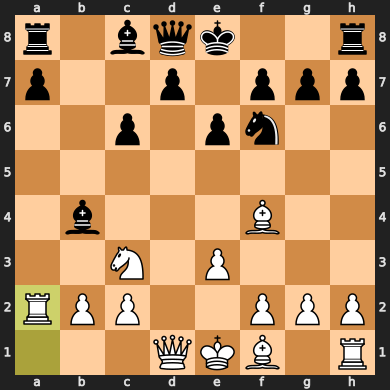

In [ ]:
board.push(chess.Move.from_uci("a1a2"))
board

Predicted move: e8g8


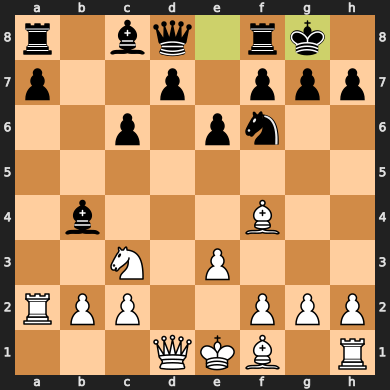

In [ ]:
tensor = board_to_tensor(board)  # shape (13, 8, 8)
tensor = torch.tensor(tensor, dtype=torch.float32).unsqueeze(0)  # add batch dim
tensor = tensor.to(device)
with torch.no_grad():
  output = model(tensor)  # shape: [1, 1800]
  predicted_index = torch.argmax(output, dim=1).item()
predicted_move = int_to_moves[predicted_index]
print("Predicted move:", predicted_move)
move = chess.Move.from_uci(predicted_move)
board.push(move)
board
